# Regional song data for Rocksmith+

In [1]:
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

In [2]:
conn = sqlite3.connect("songs.db")

## Number of songs by region
_There was 9203 unique songs in total between the selected regions at the time of scraping_

In [3]:
pd.read_sql("""
SELECT country, COUNT(DISTINCT songId) as "total songs"
FROM regions
GROUP BY country
ORDER BY COUNT(DISTINCT songId) DESC
""", conn)

,country,total songs
0,Colombia,6722
1,Brazil,6645
2,Venezuela,6628
3,Canada,6131
4,Australia,6113
5,United States,6103
6,Spain,5917
7,Italy,5816
8,France,5692
9,United Kingdom,5549


## Number of non-AI arrangements by region

In [4]:
pd.read_sql("""
SELECT country, SUM(s.lead+s.altLead+s.rhythm+s.altRhythm+s.bass+s.altBass) as "total arrangements"
FROM regions
INNER JOIN songs s ON
  s.songId = regions.songId
WHERE
  s.lead>0 OR s.altLead>0 OR s.rhythm>0 OR s.altRhythm>0 OR s.bass>0 OR s.altBass>0
GROUP BY country
ORDER BY SUM(s.lead+s.altLead+s.rhythm+s.altRhythm+s.bass+s.altBass) DESC
""", conn)

,country,total arrangements
0,Brazil,2077
1,Colombia,2067
2,Venezuela,2007
3,Canada,1962
4,United States,1954
5,Denmark,1778
6,Australia,1773
7,France,1769
8,Spain,1741
9,Italy,1730


## Number of songs available in all regions
_Excluding Japan which is obviously incomplete_

In [11]:
pd.read_sql("""
SELECT COUNT(songID) as "common songs" FROM (
  SELECT DISTINCT songID FROM regions WHERE country=="Australia"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Brazil"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Canada"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Colombia"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Germany"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Denmark"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Spain"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="France"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="United Kingdom"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Italy"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="United States"
  INTERSECT
  SELECT DISTINCT songID FROM regions WHERE country=="Venezuela"
)
""",conn)

,common songs
0,887


## Number of songs available between regions

In [6]:
countries = pd.read_sql("""
SELECT DISTINCT country FROM regions WHERE country!="Japan"
""",conn)
countries = sorted(list(chain(*countries.values.tolist())))

country_similarity = pd.DataFrame(columns=countries, index=countries)
for i,country_a in enumerate(countries):
    for j,country_b in enumerate(countries):
        count = pd.read_sql(f"""
            SELECT DISTINCT songID FROM regions WHERE country=="{country_a}"
            INTERSECT
            SELECT DISTINCT songID FROM regions WHERE country=="{country_b}"
            """, conn)
        count = len(count)
        country_similarity[country_a][country_b] = count
country_similarity


,Australia,Brazil,Canada,Colombia,Denmark,France,Germany,Italy,Spain,United Kingdom,United States,Venezuela
Australia,6113,4855,4525,4813,4169,4370,3767,4306,4375,4293,4197,4799
Brazil,4855,6645,4693,5396,4422,4520,4041,4486,4627,4459,4701,5188
Canada,4525,4693,6131,4717,4163,4212,3787,4184,4255,4187,4646,4699
Colombia,4813,5396,4717,6722,4395,4567,4097,4556,4608,4398,4637,5244
Denmark,4169,4422,4163,4395,5531,4399,3935,4396,4464,4296,3822,4362
France,4370,4520,4212,4567,4399,5692,4035,4432,4592,4416,3899,4424
Germany,3767,4041,3787,4097,3935,4035,5003,4020,3924,3829,3616,3983
Italy,4306,4486,4184,4556,4396,4432,4020,5816,4730,4280,3997,4451
Spain,4375,4627,4255,4608,4464,4592,3924,4730,5917,4504,4070,4533
United Kingdom,4293,4459,4187,4398,4296,4416,3829,4280,4504,5549,3908,4357


### Correlation plot for visual comparison
Brighter colors means the countries share a larger amount of songs.
Darker means the countries share fewer songs.

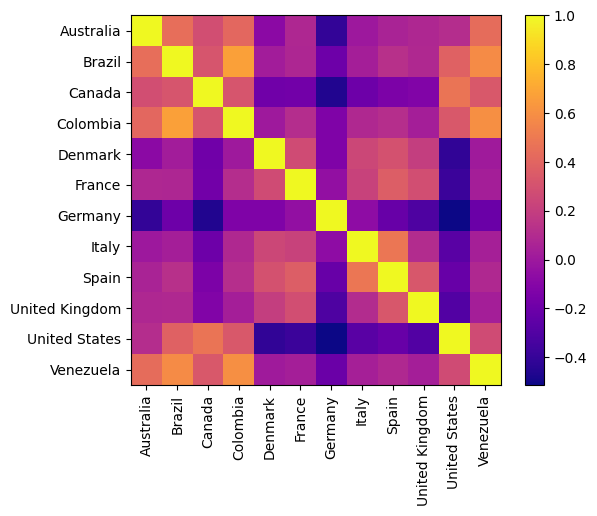

In [7]:
country_similarity_correlation = country_similarity.astype(float).corr()

# Displaying dataframe as an heatmap
# with diverging colourmap as RdYlBu
plt.imshow(country_similarity_correlation, cmap ="plasma")
  
# Displaying a color bar to understand
# which color represents which range of data
plt.colorbar()
  
# Assigning labels of x-axis 
# according to dataframe
plt.xticks(range(len(country_similarity_correlation)), country_similarity_correlation.columns, rotation=90)
  
# Assigning labels of y-axis 
# according to dataframe
plt.yticks(range(len(country_similarity_correlation)), country_similarity_correlation.index)
  
# Displaying the figure
plt.show()


## Number of songs available by region and genre
Some songs apear in multiple genres and as such the genre counts do not add up to the unique song counts listed earlier.

In [8]:
genres = pd.read_sql("""
SELECT DISTINCT genre FROM regions
""",conn)
genres = sorted(list(chain(*genres.values.tolist())))

genre_song_counts_by_region = pd.read_sql("""
SELECT country, genre, COUNT(DISTINCT songId) as "songs"
FROM regions
WHERE country != "Japan"
GROUP BY country, genre
""",conn)

genre_song_counts_by_region = pd.pivot_table(genre_song_counts_by_region, index='country', columns='genre')
genre_song_counts_by_region = genre_song_counts_by_region.fillna(0).astype(int)
genre_song_counts_by_region.columns = genre_song_counts_by_region.columns.droplevel(0)
genre_song_counts_by_region



genre,Blues,Classical,Country,Electronic,Folk,Hip-Hop,Jazz,Latin,Metal,New Age,Other,Pop,R&B,Regional Music,Rock
country,,,,,,,,,,,,,,,
Australia,172,34,517,97,252,150,78,937,364,130,98,1520,385,692,1733
Brazil,178,43,504,115,272,136,93,973,339,129,98,1720,411,754,2005
Canada,129,38,533,78,228,144,72,869,314,62,88,1679,372,634,1890
Colombia,172,43,508,97,245,145,93,969,394,141,103,1649,403,806,2037
Denmark,188,50,471,94,228,77,80,895,100,120,96,1288,338,588,1812
France,177,40,555,90,250,89,100,873,122,135,84,1414,357,600,1769
Germany,116,38,418,84,211,79,81,904,90,52,94,1284,306,608,1560
Italy,194,40,505,85,240,89,85,910,151,117,95,1416,318,617,1936
Spain,197,40,495,83,258,86,77,931,154,137,88,1552,341,670,1839


### Bar plot for visual comparison

<AxesSubplot:xlabel='genre'>

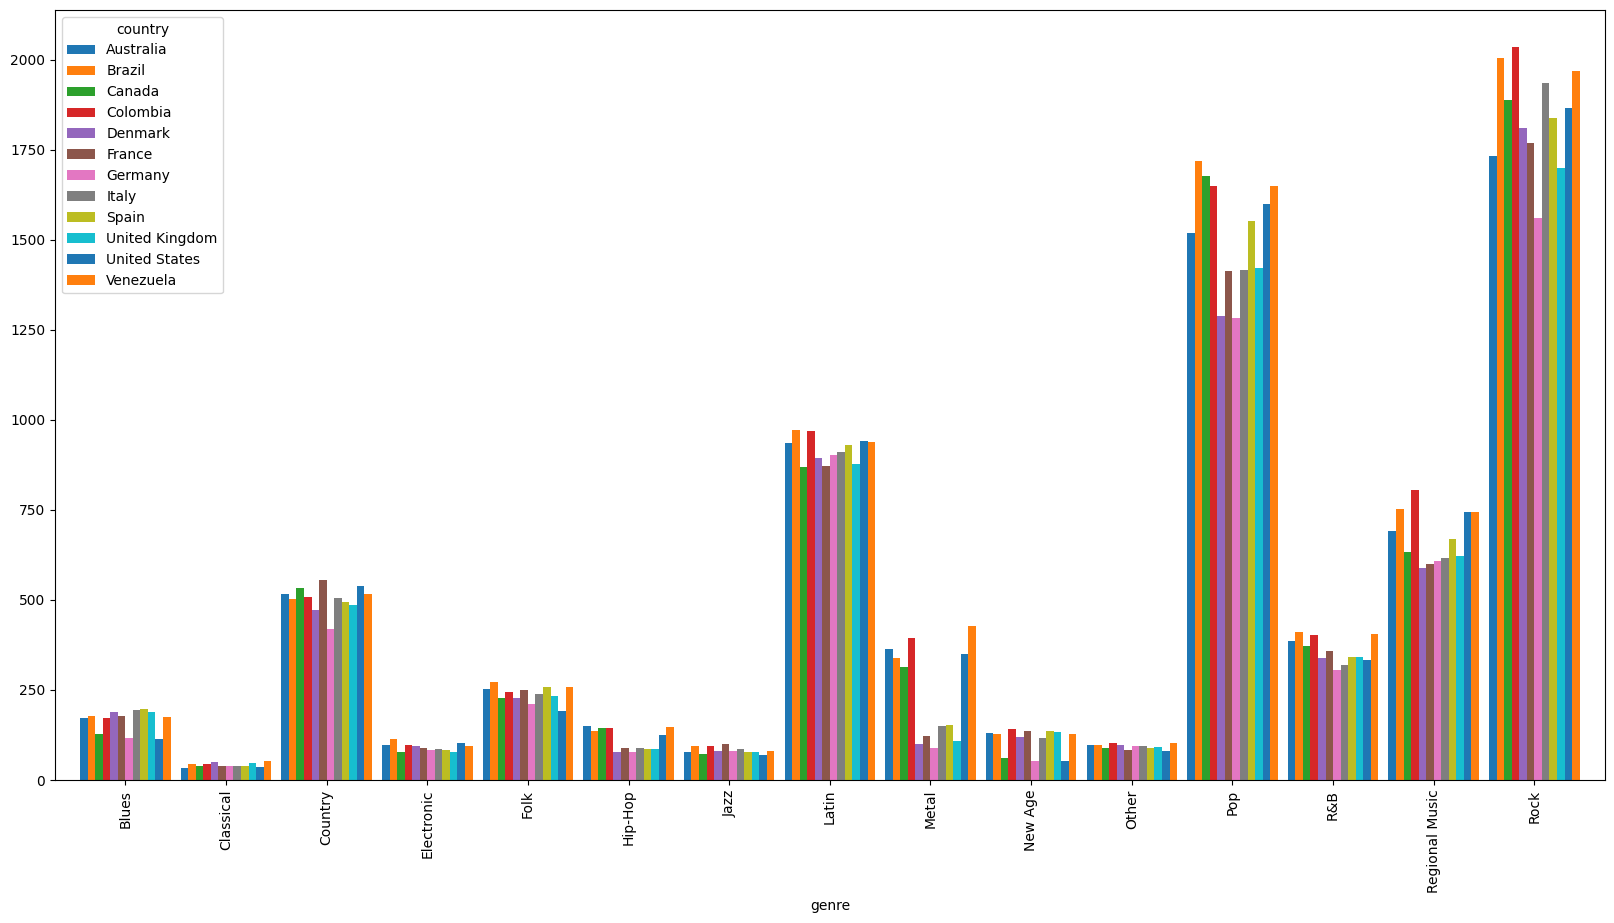

In [12]:
genre_song_counts_by_region.T.plot(kind="bar", figsize=(20, 10), width=0.9)

## BONUS: Top 10 longest songs
_songLength is in seconds_

In [10]:
pd.read_sql("""
SELECT * FROM songs
ORDER BY songLength DESC
LIMIT 10
""", conn)

,songId,songName,songYear,songLength,artistName,albumName,albumId,genre,totalArrangements,bonusAvailable,...,altBass,vocal,hasUGCGuitarArrangement,hasUGCBassArrangement,hasOfficialGuitarArrangement,hasOfficialBassArrangement,lyrics,videoRequest,tempoMapLock,verifiedTempo
0,f7e0c47f-523f-01c6-f127-3121253a7f54,Supper's Ready,2012,1415.0,Steve Hackett,Genesis Revisited II,775dcde9-dd35-9cb3-e156-f688dd45b127,Rock,2,0,...,0,0,0,0,1,1,0,0,0,0
1,b5b7d0cf-aff1-d5f0-0e36-b27b1644715c,La Fiesta Live,1978,1320.0,Herbie Hancock,An Evening With Herbie Hancock & Chick Corea I...,e8d6d2ab-e984-d743-9b03-08ed8735759f,"Jazz,Latin,Classical",2,0,...,0,0,0,0,1,0,0,0,0,0
2,2bdb77eb-2c50-521b-042b-e89ee6b96f65,Joy,2013,955.0,Isaac Hayes,The Rza Presents Shaolin Soul: Vol 1,68906374-316c-9c69-74f9-a71b0eec37d8,R&B,2,0,...,0,0,0,0,0,0,0,0,0,0
3,d03417e1-2c50-5671-2cfc-9bab53db6d29,Medley: One / Take 5 Live at the Olympia Theatre,2016,910.0,Rodrigo y Gabriela,Rodrigo Y Gabriela (Deluxe Edition),51a77cc0-ab74-14bb-5f29-48fa59152f19,Regional Music,2,0,...,0,0,0,0,0,0,0,0,0,0
4,0e42cbfd-48cc-ce81-9362-1021601b4574,"Soul Sacrifice / Head, Hands & Feet",1977,839.0,Santana,Moonflower,6882da7e-342c-923f-4cec-592c0dd88c1d,"Rock,Latin",2,0,...,0,0,0,0,0,0,0,0,0,0
5,d377750b-f1f2-30b8-0da5-c98e531b8398,Velvet Thorns (Of Drynwhyl),2007,837.0,Katatonia,Dance of December Souls,053ae273-4b93-e146-67ba-3762f1f5b06e,Metal,2,0,...,0,0,0,0,0,0,0,0,0,0
6,49448c01-0cfa-a9cd-b457-6c487bd374fb,By the Pain I See in Others,2002,830.0,Opeth,Deliverance,795059a6-65d0-4774-1529-da48373ab359,Rock,1,0,...,0,0,0,0,1,0,0,0,0,0
7,7a950e6c-5a47-b48c-d6e1-d58f91584806,Metanoia,2008,826.0,MGMT,Time To Pretend,c87e97a8-b1c1-4bd8-ed35-d067cfe6a4ab,Rock,2,0,...,0,0,0,0,1,0,0,0,0,0
8,cf98c238-737c-3d26-0a2b-309ade71a877,Chachaseando (Pensando En Ti) Popurri:,1998,821.0,Juan Gabriel,Celebrando 25 Años De Juan Gabriel En El Palac...,205a8cba-f578-06a5-b903-36e6408cf5a7,Regional Music,2,0,...,0,0,0,0,0,0,0,0,0,0
9,4266d3e4-4349-0dcc-9d7b-468e3da9c751,Hearts Alive,2004,819.0,Mastodon,Leviathan,c556e52c-4e3c-4710-a923-a2a0bdb77b28,Metal,2,0,...,0,0,0,0,1,0,0,0,0,0
